In [1]:
#librerias para exploracion de datos
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import tensorflow as tf

#libreias para ploteo
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno


pd.options.display.float_format='{:,.2f}'.format #damos formato de dos decimales para mejor visualizacion de los datos
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
#exploracion de datos
df_test = pd.read_excel(r'D:\Proyectos\Datathon\bike_test.xlsx')
df_train = pd.read_excel(r'D:\Proyectos\Datathon\bike_train.xlsx')

Normalización de campos

In [3]:
#dividimos los datos por año, mes y día
df_test['year'] = df_test['dteday'].apply(lambda x : x.year)
df_test['month'] = df_test['dteday'].apply(lambda x : x.month)
df_test['day'] = df_test['dteday'].apply(lambda x : x.day)

df_train['year'] = df_train['dteday'].apply(lambda x : x.year)
df_train['month'] = df_train['dteday'].apply(lambda x : x.month)
df_train['day'] = df_train['dteday'].apply(lambda x : x.day)

In [4]:
df_train.columns, df_test.columns

(Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
        'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
        'casual', 'registered', 'cnt', 'year', 'month', 'day'],
       dtype='object'),
 Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
        'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'year',
        'month', 'day'],
       dtype='object'))

In [110]:
#eliminamos columnas ya normalizadas y los que no usaremos
df_train.drop(columns={'instant', 'dteday', 'yr', 'mnth', 'casual', 'registered'}, inplace=True)
df_test.drop(columns={'instant', 'dteday', 'yr', 'mnth'}, inplace=True)
#ordennamos los campos, para una mejor visualización de los datos
df_test = df_test[['instant', 'year', 'month', 'day', 'hr', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
df_train = df_train[['instant', 'year', 'month', 'day', 'hr', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']]

In [5]:
df_train.drop(columns={'dteday', 'yr', 'mnth', 'casual', 'registered'}, inplace=True)
df_test.drop(columns={'dteday', 'yr', 'mnth'}, inplace=True)

In [6]:
#ordennamos los campos, para una mejor visualización de los datos
df_test = df_test[['year', 'month', 'day', 'hr', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
df_train = df_train[['year', 'month', 'day', 'hr', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']]

________________

Análisis de datos de entrenamiento

In [7]:
df_train.head(3)

,year,month,day,hr,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011,1,1,0,1,0,6,0,1,0.24,0.29,0.81,0.00,16
1,2011,1,1,1,1,0,6,0,1,0.22,0.27,0.80,0.00,40
2,2011,1,1,2,1,0,6,0,1,0.22,0.27,0.80,0.00,32


In [8]:
df_train.info() #cantidad, nulos y tipo de datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        11999 non-null  int64  
 1   month       11999 non-null  int64  
 2   day         11999 non-null  int64  
 3   hr          11999 non-null  int64  
 4   season      11999 non-null  int64  
 5   holiday     11999 non-null  int64  
 6   weekday     11999 non-null  int64  
 7   workingday  11999 non-null  int64  
 8   weathersit  11999 non-null  int64  
 9   temp        11999 non-null  float64
 10  atemp       11999 non-null  float64
 11  hum         11999 non-null  float64
 12  windspeed   11999 non-null  float64
 13  cnt         11999 non-null  int64  
dtypes: float64(4), int64(10)
memory usage: 1.3 MB


<AxesSubplot:>

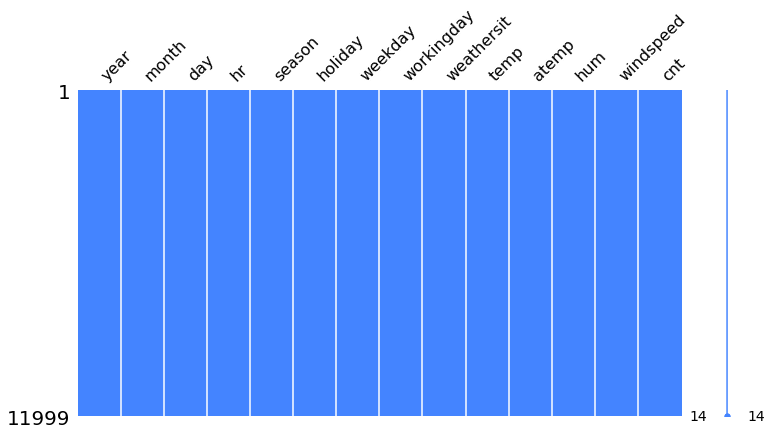

In [9]:
#calidad de los datos de la data para el entrenamiento
msno.matrix(df_train, figsize=(12,6),color=(0.27, 0.52, 1.0)) #0.3,0.36,0.44 / 1, 0.38, 0.27 / 0.27, 0.52, 1.0

se puede apreciar que se cuenta con los datos completos

In [10]:
#definimos los campos para obtener una descripción general de los datos 
df_train_analisis = df_train[['month', 'day', 'hr', 'season', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']]
df_train_analisis.describe()

,month,day,hr,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,"11,999.00","11,999.00","11,999.00","11,999.00","11,999.00","11,999.00","11,999.00","11,999.00","11,999.00","11,999.00","11,999.00","11,999.00","11,999.00"
mean,5.53,15.45,11.56,2.21,0.03,3.01,0.68,1.44,0.47,0.45,0.63,0.20,158.59
std,3.43,8.75,6.91,1.09,0.16,2.01,0.46,0.65,0.19,0.17,0.20,0.13,151.39
min,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.02,0.00,0.00,0.00,1.00
25%,3.00,8.00,6.00,1.00,0.00,1.00,0.00,1.00,0.32,0.30,0.47,0.10,34.00
50%,5.00,15.00,12.00,2.00,0.00,3.00,1.00,1.00,0.46,0.45,0.62,0.19,118.00
75%,8.00,23.00,18.00,3.00,0.00,5.00,1.00,2.00,0.62,0.59,0.79,0.28,232.00
max,12.00,31.00,23.00,4.00,1.00,6.00,1.00,4.00,0.96,1.00,1.00,0.85,957.00


array([[<AxesSubplot:xlabel='hr', ylabel='hr'>,
        <AxesSubplot:xlabel='season', ylabel='hr'>,
        <AxesSubplot:xlabel='holiday', ylabel='hr'>,
        <AxesSubplot:xlabel='weekday', ylabel='hr'>,
        <AxesSubplot:xlabel='workingday', ylabel='hr'>,
        <AxesSubplot:xlabel='weathersit', ylabel='hr'>,
        <AxesSubplot:xlabel='temp', ylabel='hr'>,
        <AxesSubplot:xlabel='atemp', ylabel='hr'>,
        <AxesSubplot:xlabel='hum', ylabel='hr'>,
        <AxesSubplot:xlabel='windspeed', ylabel='hr'>,
        <AxesSubplot:xlabel='cnt', ylabel='hr'>],
       [<AxesSubplot:xlabel='hr', ylabel='season'>,
        <AxesSubplot:xlabel='season', ylabel='season'>,
        <AxesSubplot:xlabel='holiday', ylabel='season'>,
        <AxesSubplot:xlabel='weekday', ylabel='season'>,
        <AxesSubplot:xlabel='workingday', ylabel='season'>,
        <AxesSubplot:xlabel='weathersit', ylabel='season'>,
        <AxesSubplot:xlabel='temp', ylabel='season'>,
        <AxesSubplot:xlabel='at

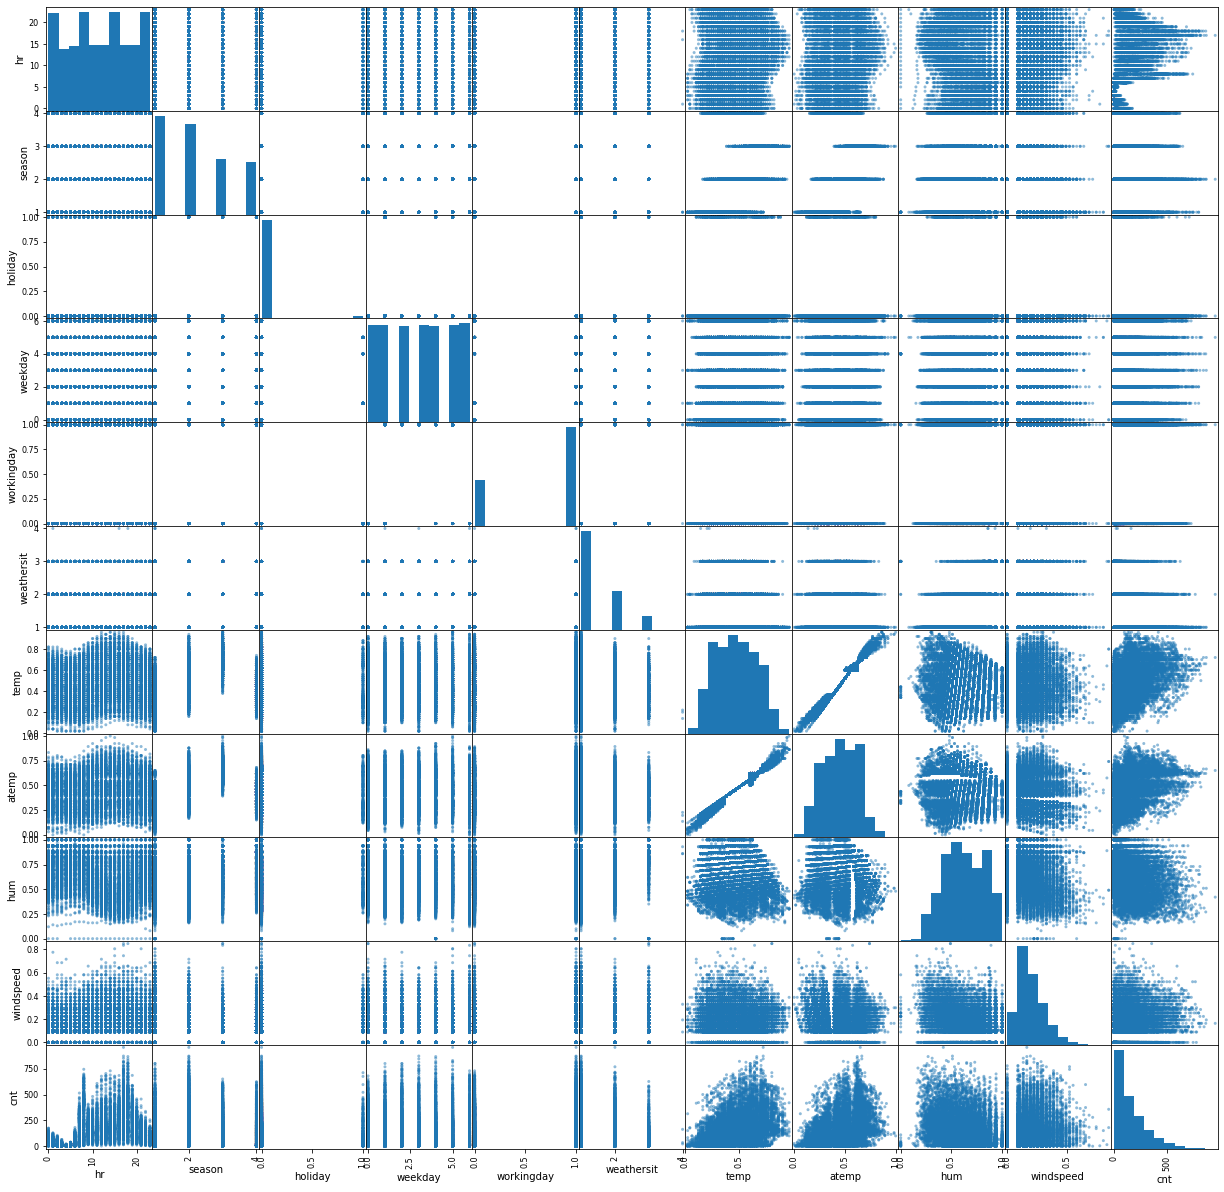

In [68]:
#visualización de la estructura de los datos previos
scatter_matrix(df_train_analisis, figsize=(21,21))

In [11]:
#calculando la matriz de correlacion de todo los datos
corr = df_train.corr()

<AxesSubplot:>

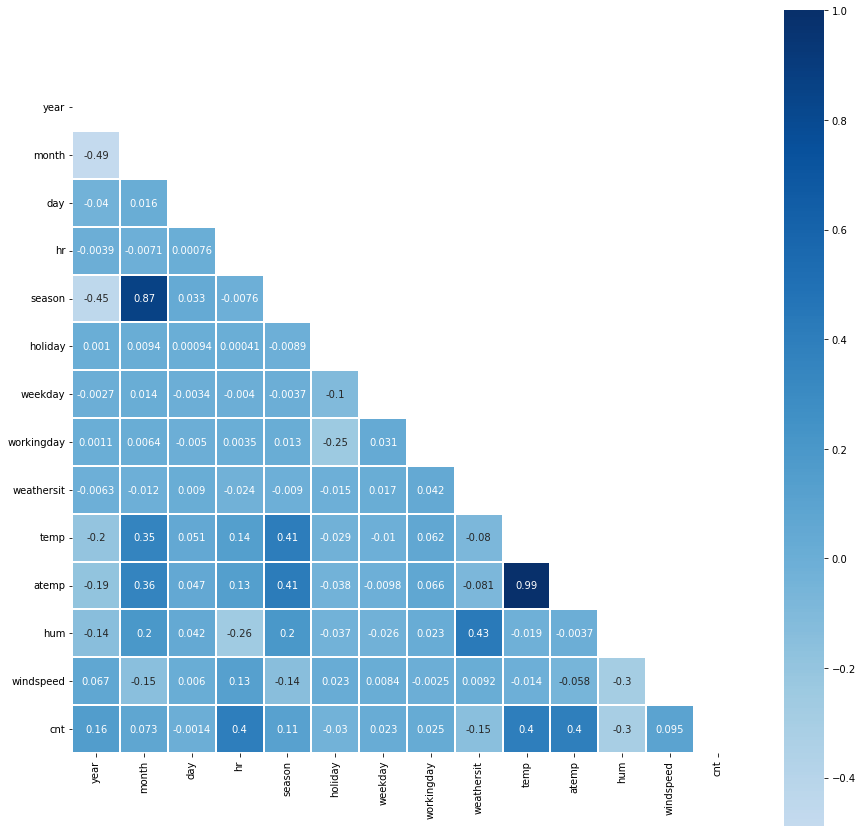

In [24]:
#generando mascara para el triangulo superior 
mask = np.triu(np.ones_like(corr, dtype=bool))
#figura para ploteo
f , ax = plt.subplots(figsize=(15,15))
#dibuja el mapa de calor con la máscara y la relación de aspecto correcto
sns.heatmap(corr, mask=mask, cmap='Blues',  vmax=1, center=0,
            square=True, linewidths=.1, annot=True)

In [12]:
df_train_analisis.columns

Index(['month', 'day', 'hr', 'season', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [19]:
list_plot = ['month', 'day', 'season', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'atemp', 'hum', 'windspeed', 'cnt']

In [14]:
#Probar si una serie de tiempo dada es estacionaria o no
from statsmodels.tsa.stattools import adfuller
for i in list_plot:
    x = df_train[i].values
    x = np.nan_to_num(x)
    result = adfuller(x)
    print(i), print('ADF static: %f' % result[0]), print('p-value: %f' % result[1]), print('Critical values')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

month
ADF static: -1.951467
p-value: 0.308250
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
day
ADF static: -6.941984
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
hr
ADF static: -16.402379
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
season
ADF static: -1.836901
p-value: 0.362301
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
holiday
ADF static: -15.395308
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
weekday
ADF static: -17.681288
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
workingday
ADF static: -19.455652
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
weathersit
ADF static: -21.264111
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
temp
ADF static: -3.947775
p-value: 0.001710
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
atemp
ADF static: -4.367757
p-value: 0.000338
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.

month


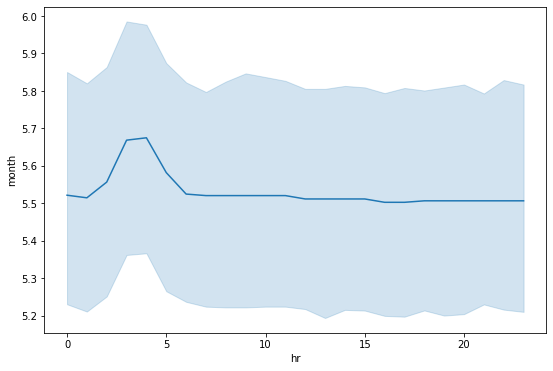

day


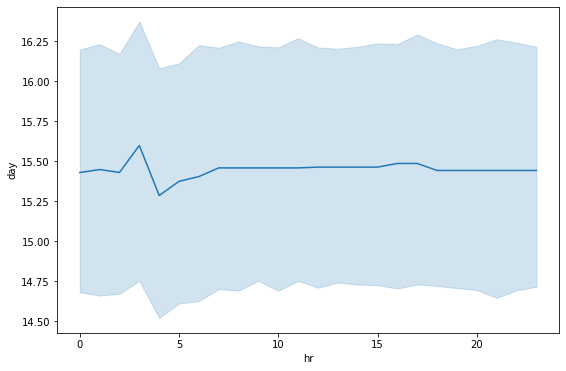

season


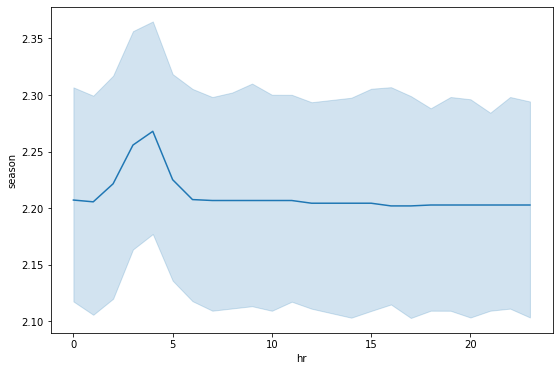

holiday


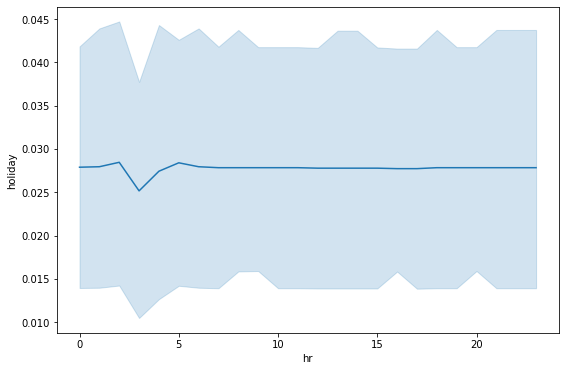

weekday


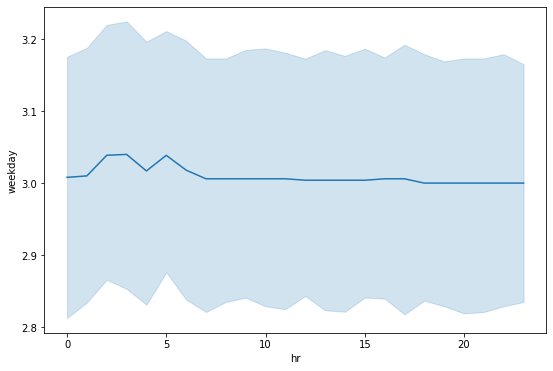

workingday


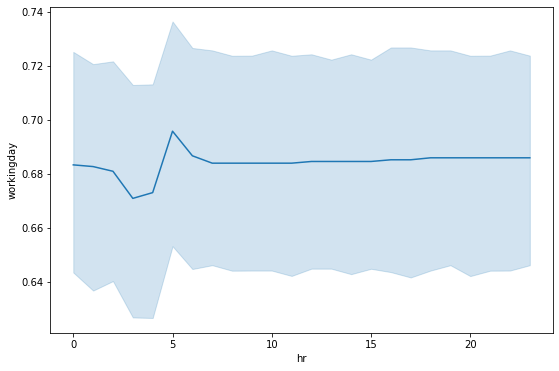

weathersit


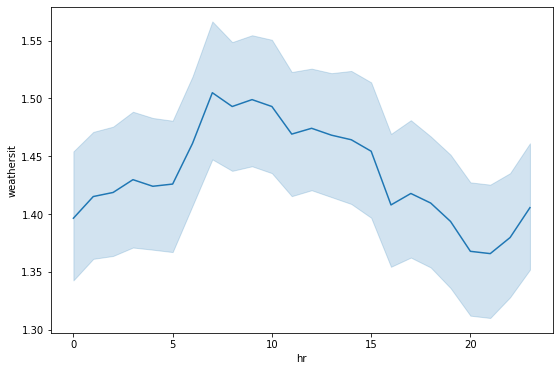

temp


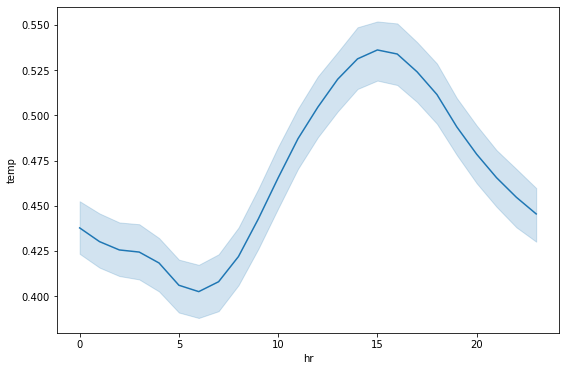

atemp


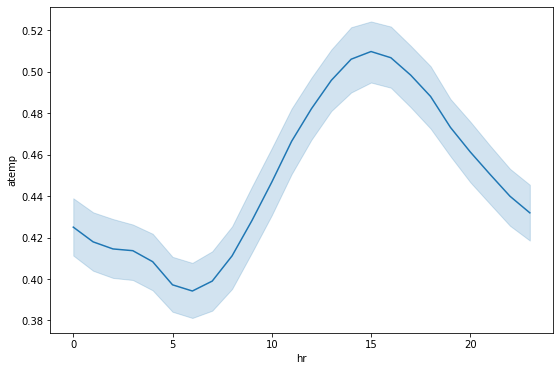

hum


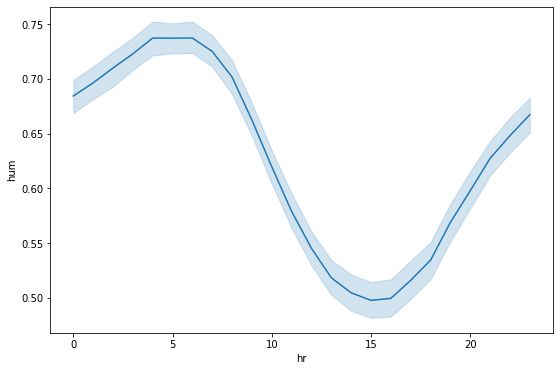

windspeed


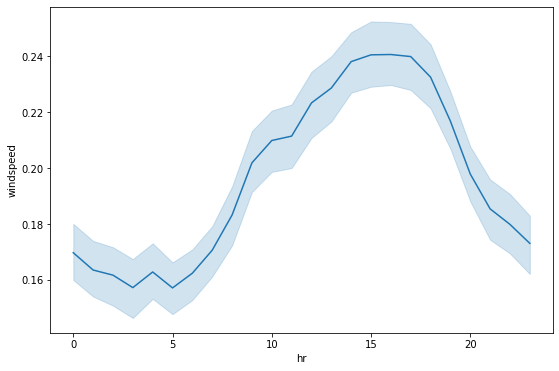

cnt


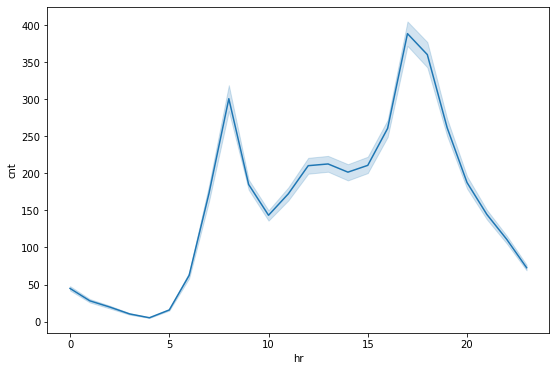

In [21]:
for i in list_plot:
    print(i)
    fig, ax =plt.subplots(figsize=(9,6))
    sns.lineplot(data=df_train, y=i, x='hr')
    plt.show()

month


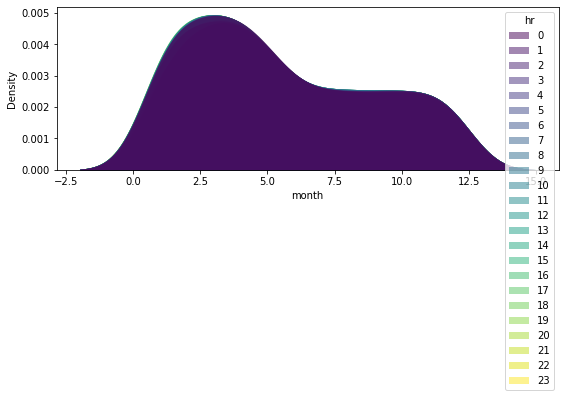

day


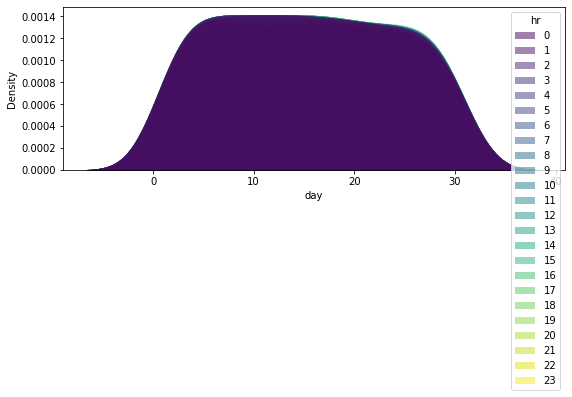

season


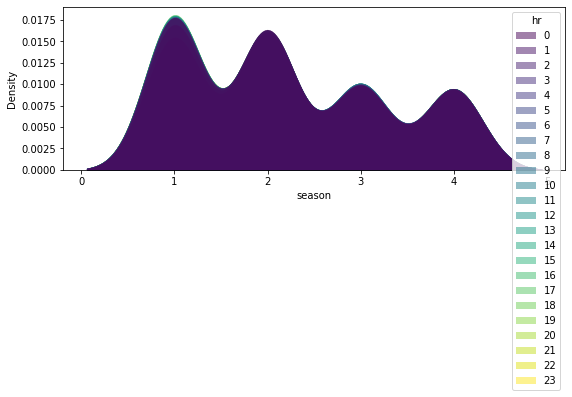

holiday


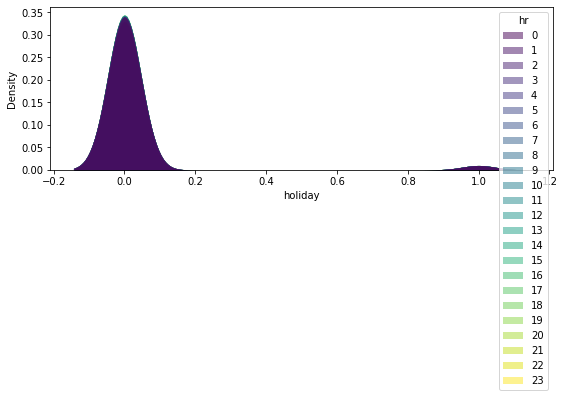

weekday


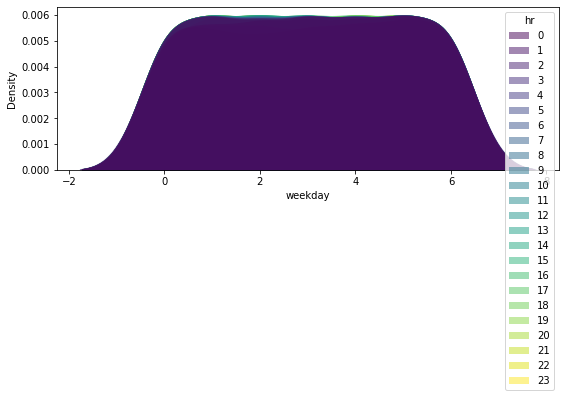

workingday


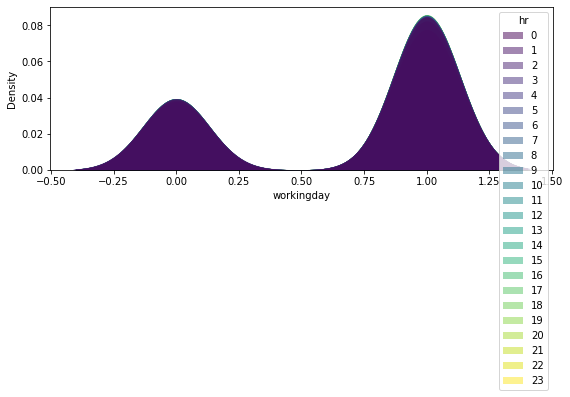

weathersit


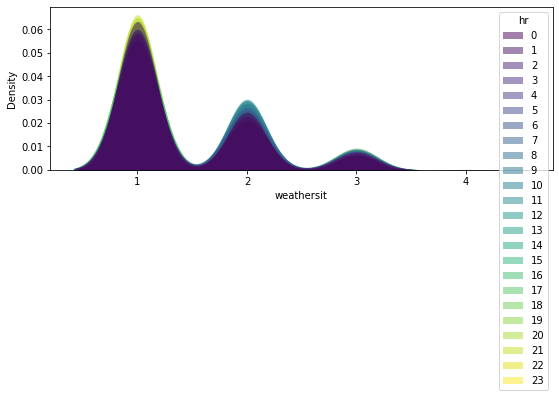

temp


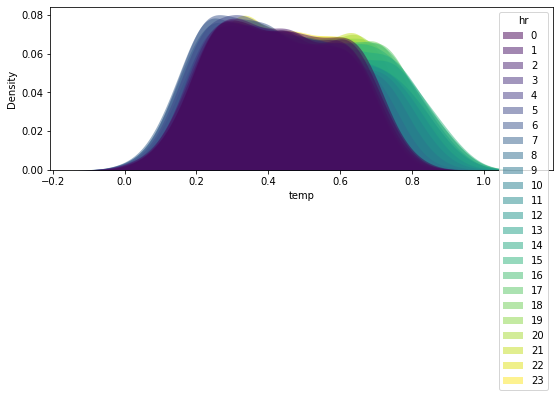

atemp


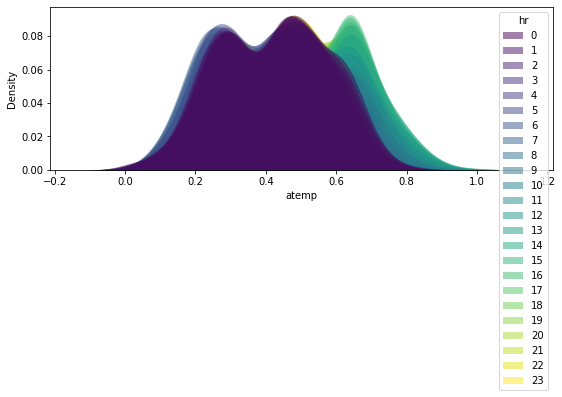

hum


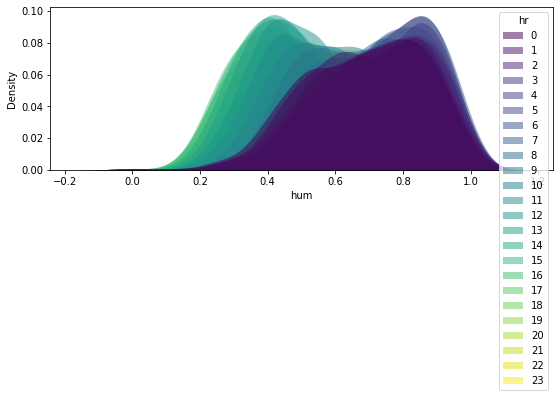

windspeed


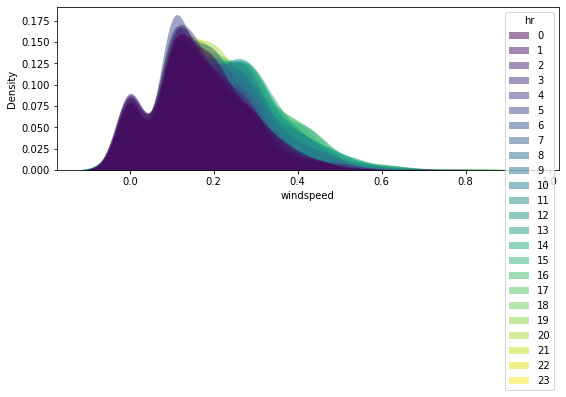

cnt


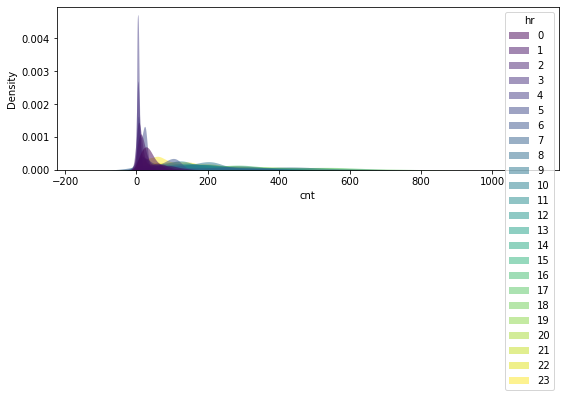

In [22]:
for i in list_plot:
    print(i)
    fig, ax =plt.subplots(figsize=(9,3))
    sns.kdeplot(data=df_train, x=i, hue='hr', fill=True, alpha=.5, linewidth=0, palette='viridis')
    plt.show()

month


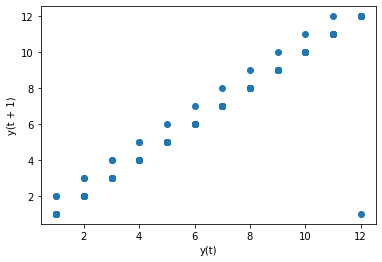

day


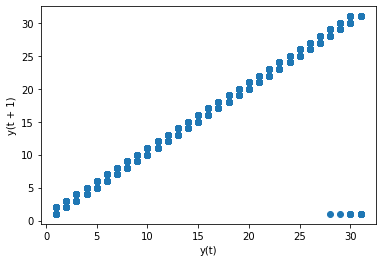

season


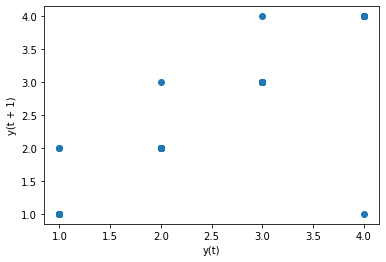

holiday


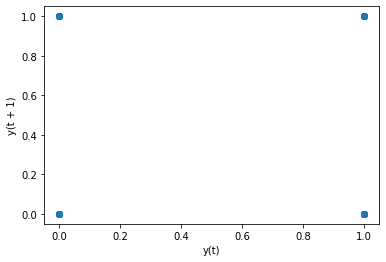

weekday


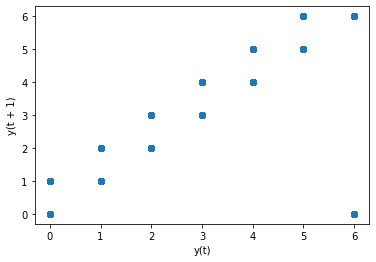

workingday


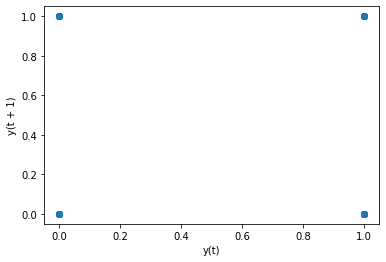

weathersit


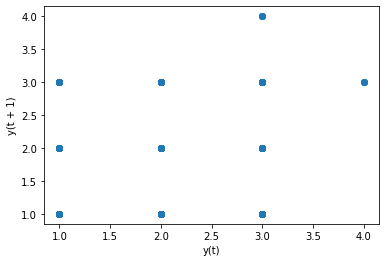

temp


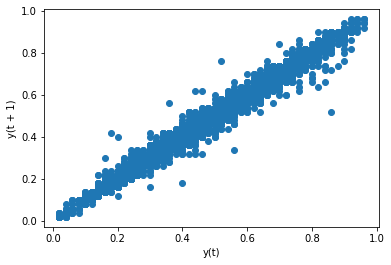

atemp


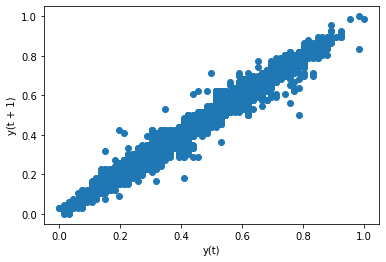

hum


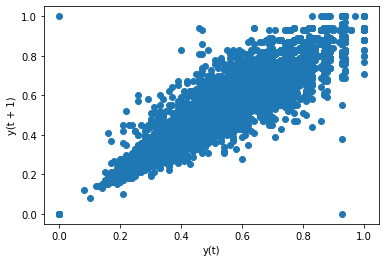

windspeed


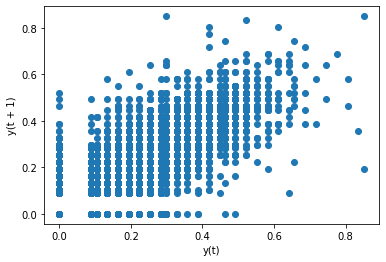

cnt


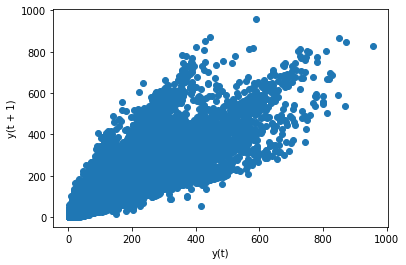

In [23]:
from pandas.plotting import lag_plot
for i in list_plot:
    print(i)
    lag_plot(df_train[i])
    plt.show()

Análisis de la diferenciacion

In [53]:
df_train_diff = df_train[['year','month', 'day', 'hr', 'season', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']].diff()

<AxesSubplot:>

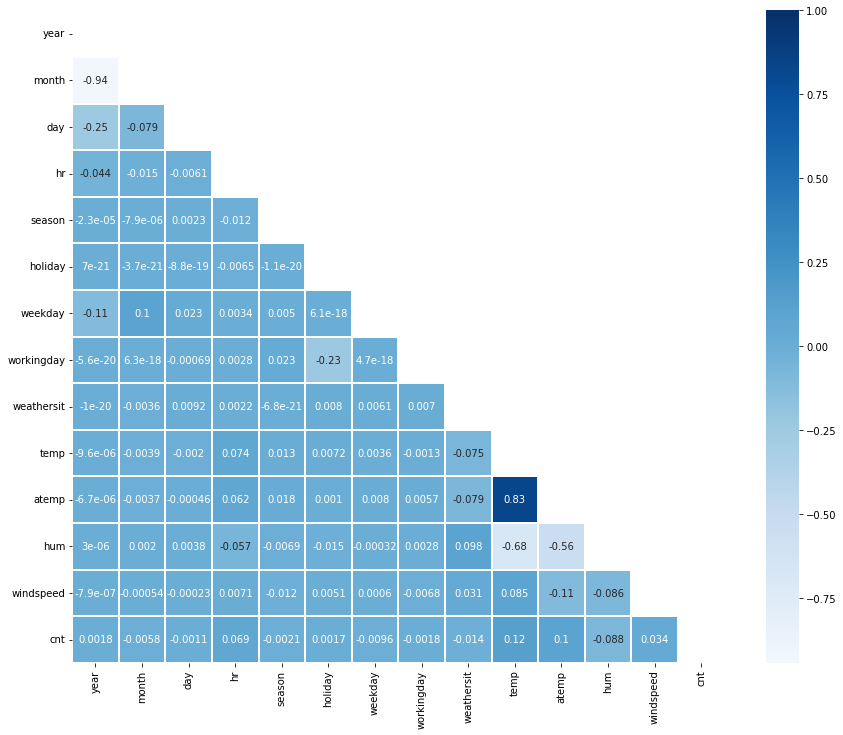

In [54]:
corr_diff = df_train_diff.corr(method='pearson')
#generando mascara para el triangulo superior
mask = np.triu(np.ones_like(corr_diff, dtype=bool))

#figura para ploteo
f , ax = plt.subplots(figsize=(15,12))

#dibuja el mapa de calor con la máscara y la relación de aspecto correcto
sns.heatmap(corr_diff, mask=mask, cmap='Blues',  vmax=1, center=0,
            square=True, linewidths=.1, annot=True)

In [52]:
list_plot = ['month', 'day', 'season', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'atemp', 'hum', 'windspeed', 'cnt']

month


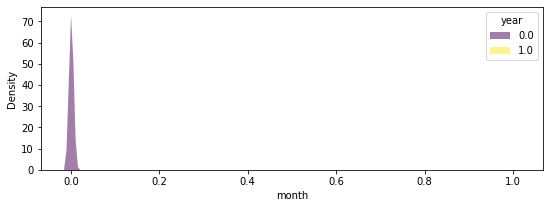

day


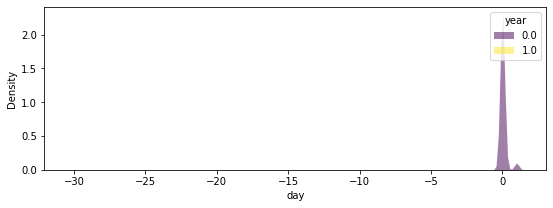

season


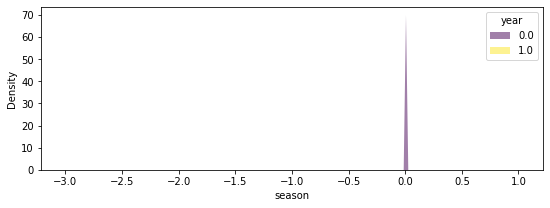

holiday


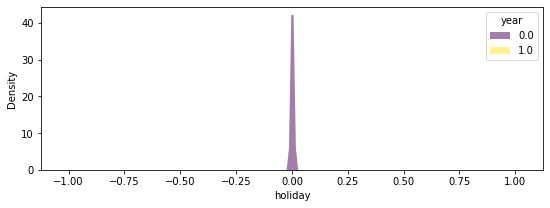

weekday


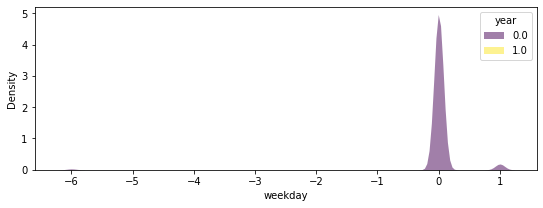

workingday


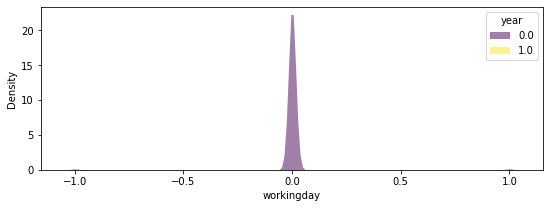

weathersit


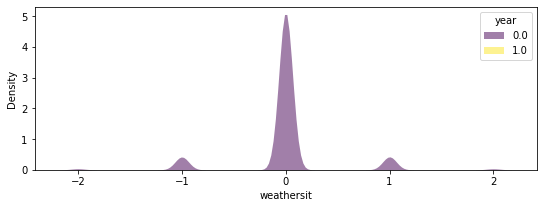

temp


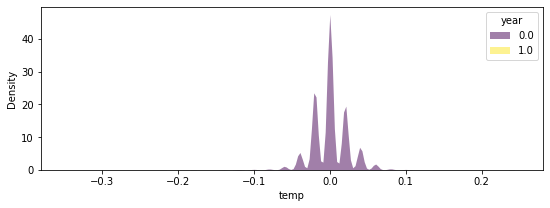

atemp


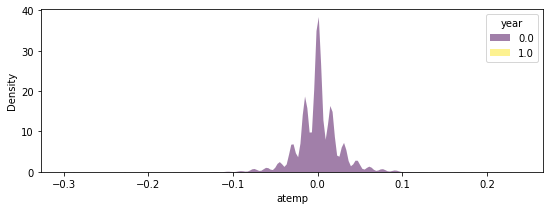

hum


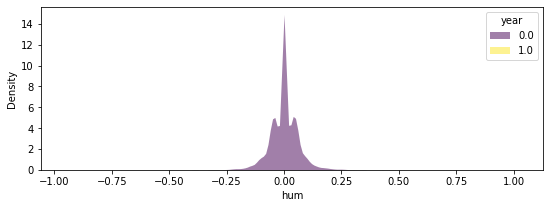

windspeed


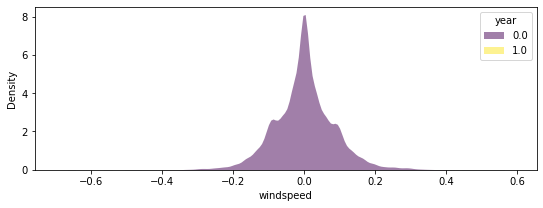

cnt


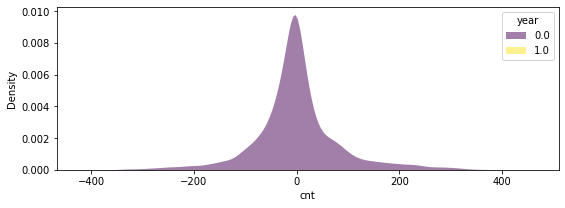

In [55]:
for i in list_plot:
    print(i)
    fig, ax =plt.subplots(figsize=(9,3))
    sns.kdeplot(data=df_train_diff, x=i, hue='year', fill=True, alpha=.5, linewidth=0, palette='viridis', warn_singular=False)
    plt.show()

<AxesSubplot:>

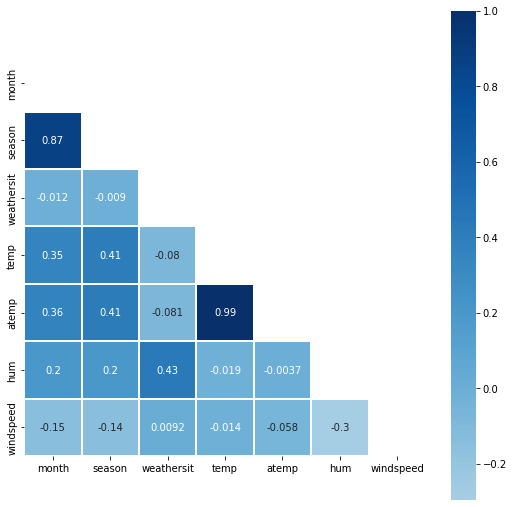

In [42]:
corr_diff = df_train_log.corr(method='pearson')
#generando mascara para el triangulo superior
mask = np.triu(np.ones_like(corr_diff, dtype=bool))

#figura para ploteo
f , ax = plt.subplots(figsize=(9,9))

#dibuja el mapa de calor con la máscara y la relación de aspecto correcto
sns.heatmap(corr_diff, mask=mask, cmap='Blues',  vmax=1, center=0,
            square=True, linewidths=.1, annot=True)

month


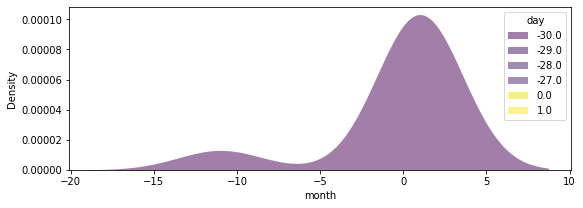

day


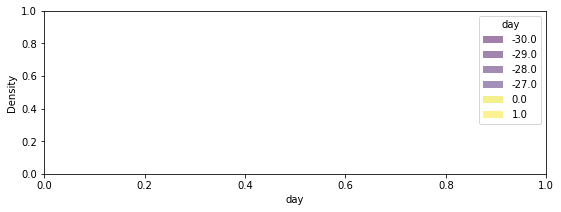

season


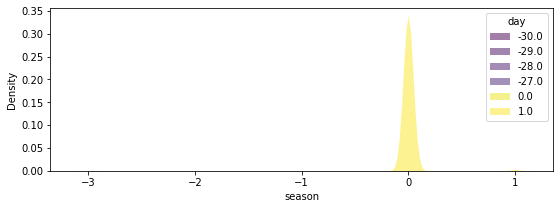

holiday


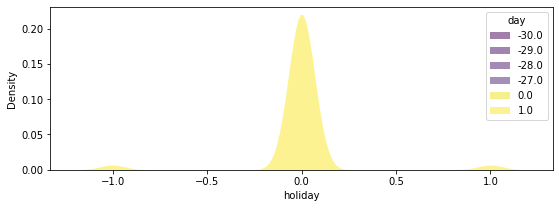

weekday


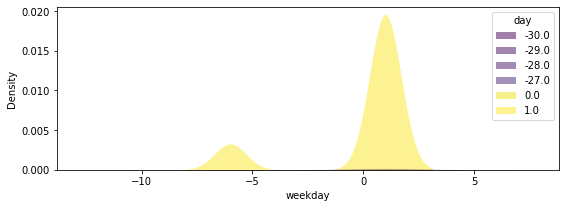

workingday


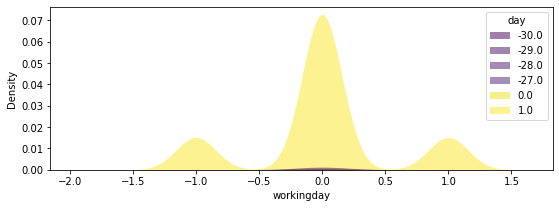

weathersit


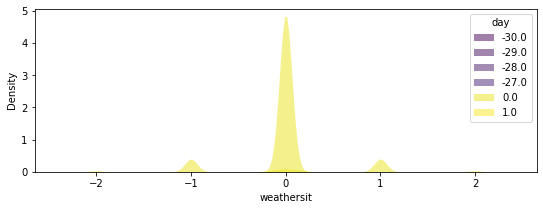

temp


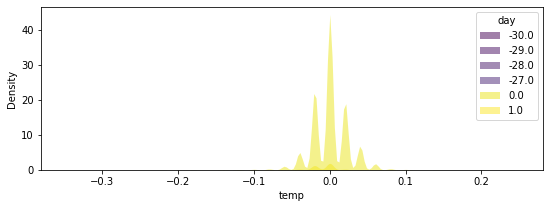

atemp


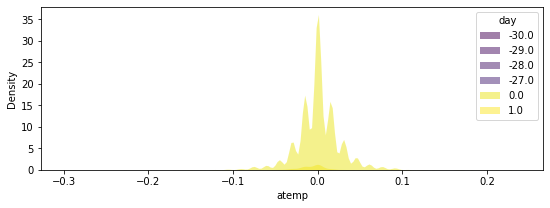

hum


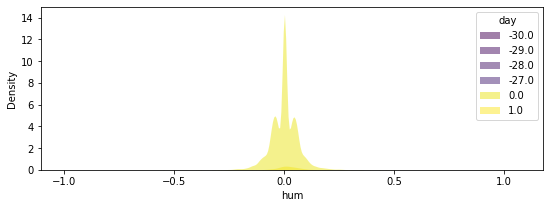

windspeed


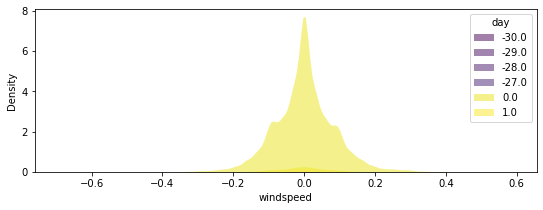

cnt


ValueError: Could not interpret value `cnt` for parameter `x`

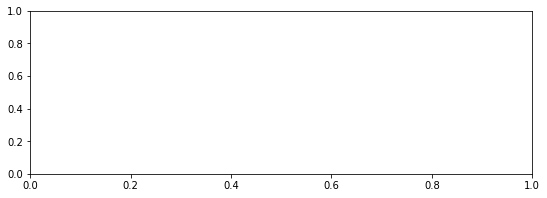

In [39]:
for i in list_plot:
    print(i)
    fig, ax =plt.subplots(figsize=(9,3))
    sns.kdeplot(data=df_train_diff, x=i, hue='day', fill=True, alpha=.5, linewidth=0, palette='viridis', warn_singular=False)
    plt.show()

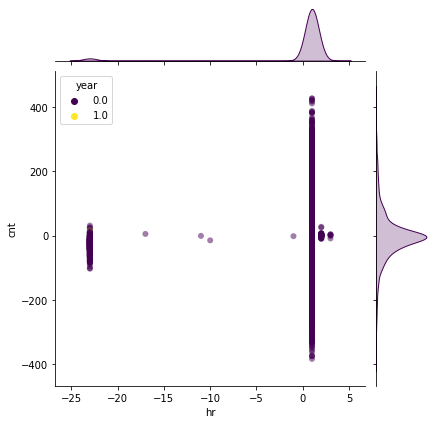

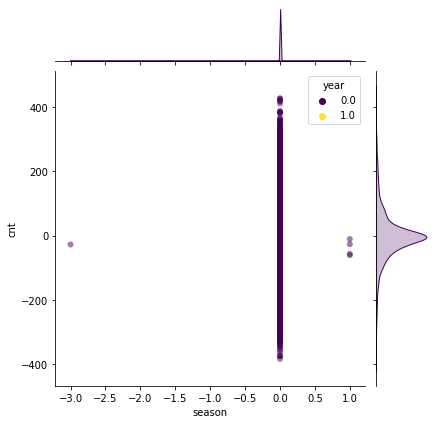

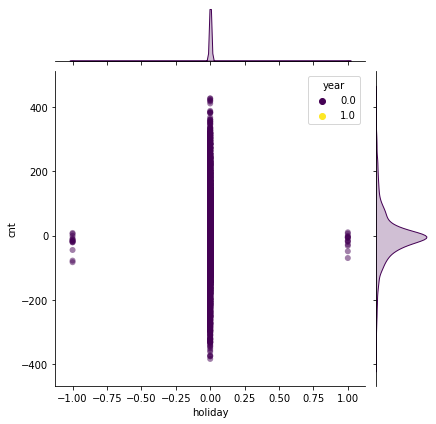

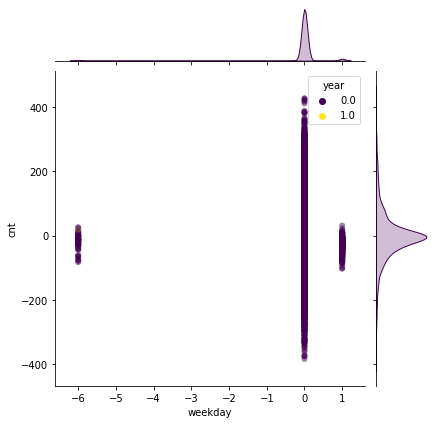

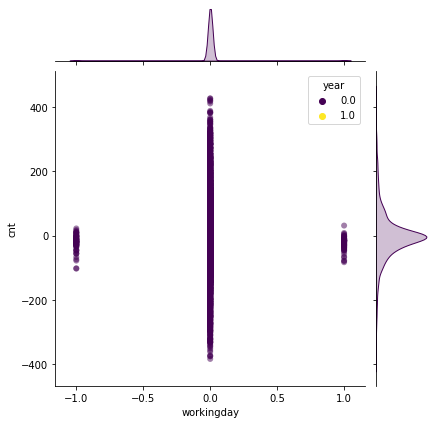

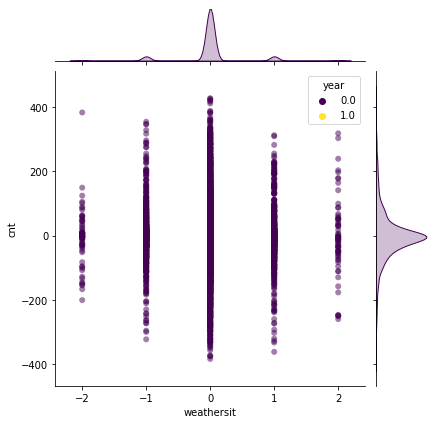

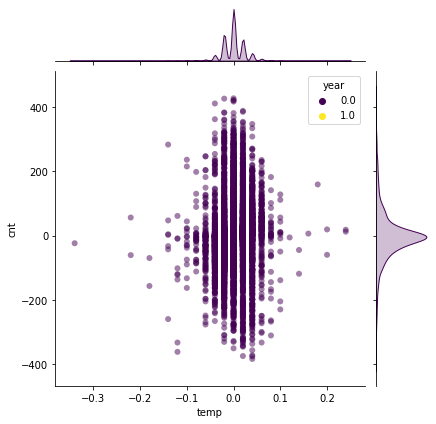

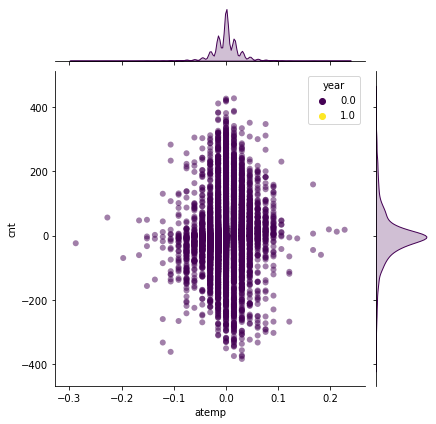

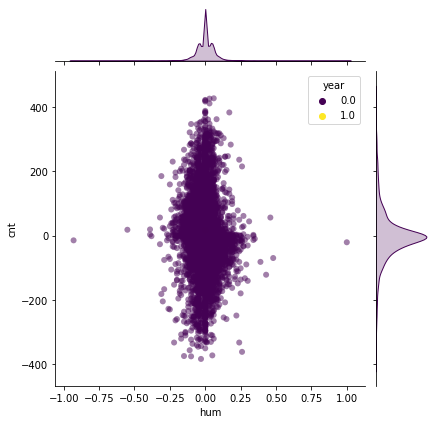

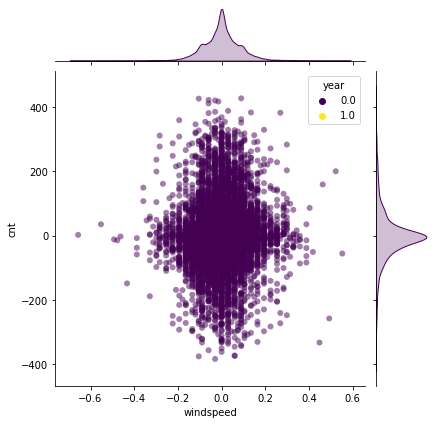

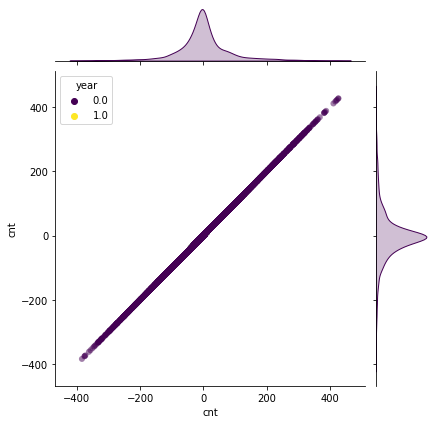

In [51]:
for i in list_plot:
    sns.jointplot(data=df_train_diff, y='cnt', x=i, hue='year', alpha=.5, linewidth=0, palette='viridis')
    plt.show()

In [52]:
from statsmodels.tsa.stattools import adfuller
for i in list_plot:
    x = df_train_diff[i].values
    x = np.nan_to_num(x)
    result = adfuller(x)
    print(i), print('ADF static: %f' % result[0]), print('p-value: %f' % result[1]), print('Critical values')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

hr
ADF static: -36.519882
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
season
ADF static: -109.526955
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
holiday
ADF static: -36.318954
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
weekday
ADF static: -26.224770
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
workingday
ADF static: -109.526253
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
weathersit
ADF static: -24.529621
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
temp
ADF static: -23.879297
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
atemp
ADF static: -23.661217
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
hum
ADF static: -26.798742
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
windspeed
ADF static: -27.037150
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.86

comparamos los dos series de tiempos (data original y de diferenciación)

month


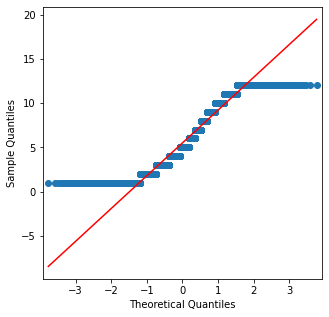

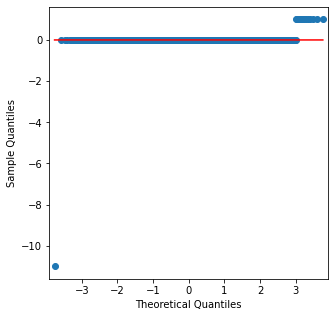

day


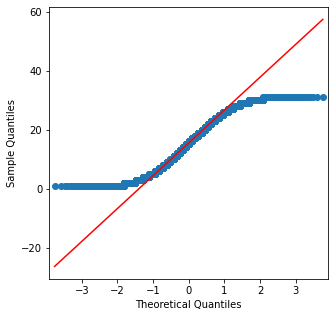

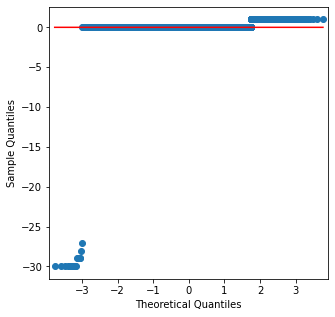

season


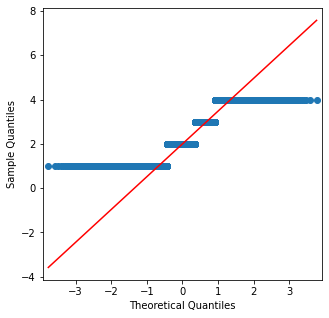

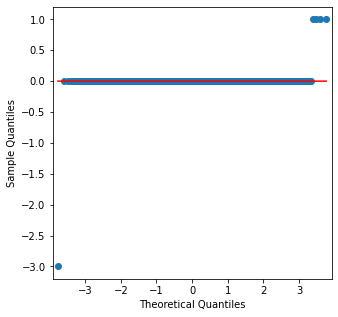

holiday


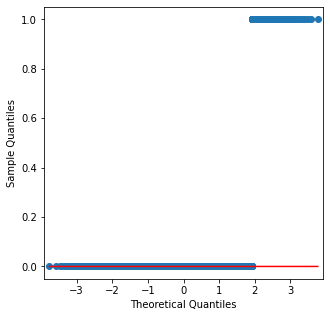

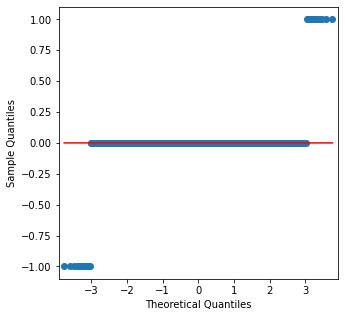

weekday


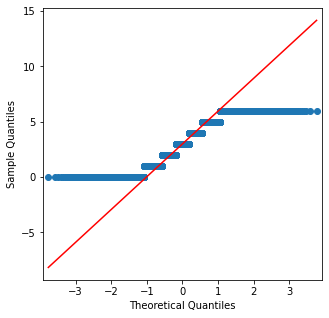

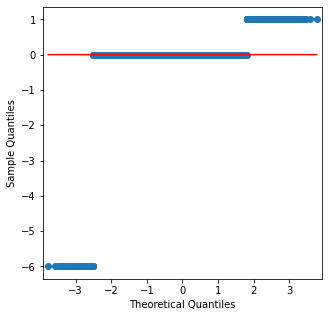

workingday


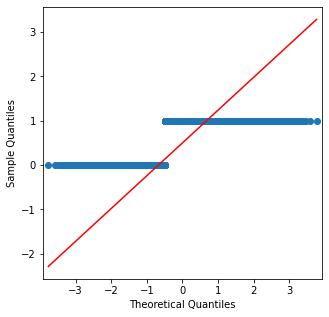

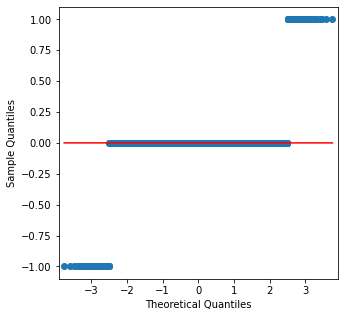

weathersit


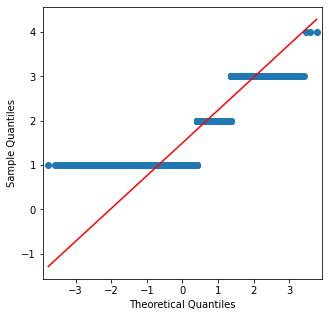

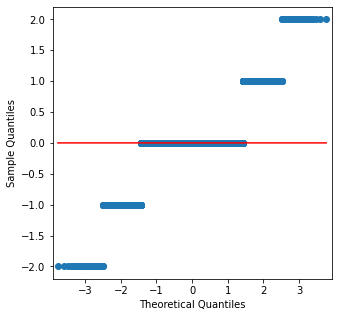

temp


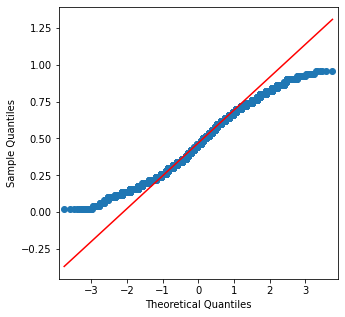

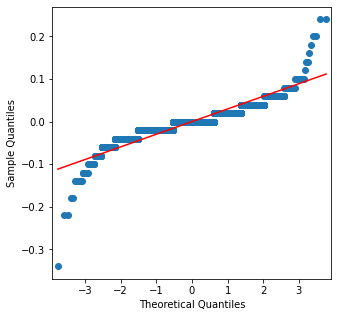

atemp


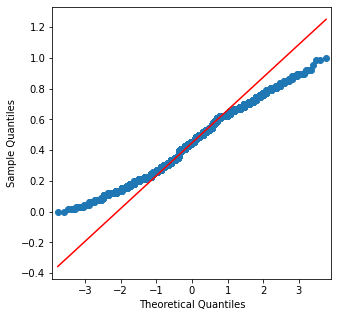

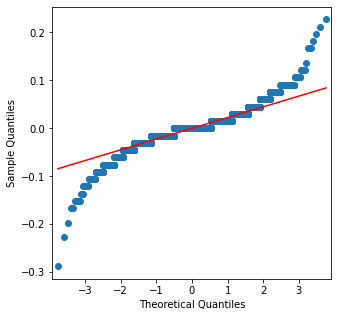

hum


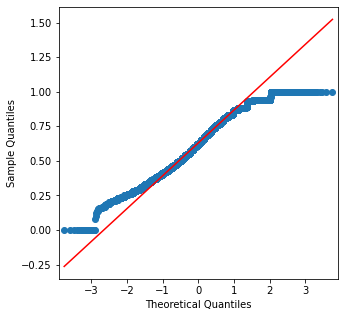

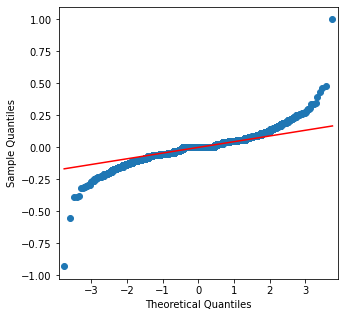

windspeed


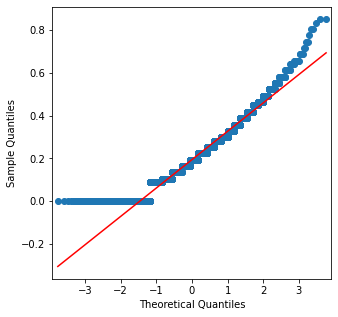

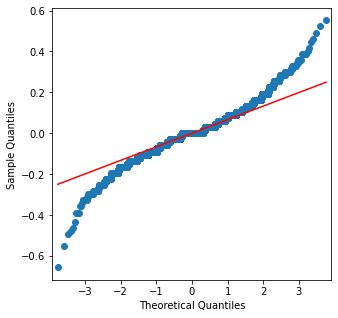

cnt


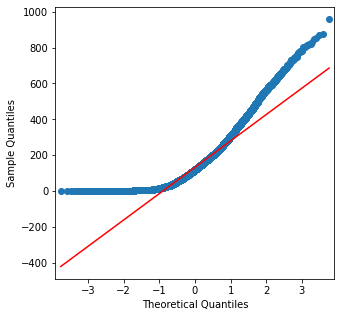

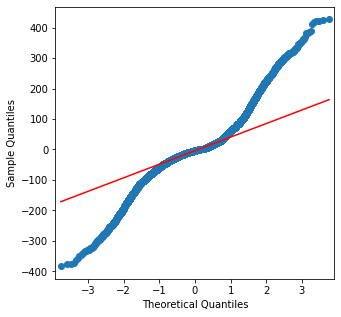

In [56]:
from statsmodels.graphics.gofplots import qqplot
for i in list_plot:
    print (i)
    y = df_train[i].fillna(0)
    x = df_train_diff[i].fillna(0)
    plt.rc('figure', figsize=(5,5), )
    qqplot(y, line='q')
    qqplot(x, line='q')
    plt.show()

_____________

extraemos datos para entrenamiento y logaritmo a la cantidad

In [57]:
train_target = df_train['cnt']
train_feature = df_train.drop(['cnt'], axis=1)
train_target.shape, train_feature.shape

((11999,), (11999, 13))

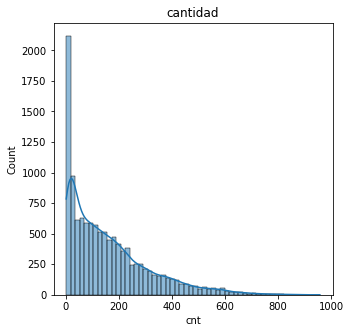

In [61]:
# cantidad histogram 
plt.title('cantidad')
sns.histplot(train_target, kde=True)
plt.show()

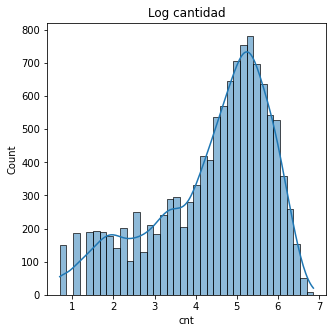

In [60]:
# train_target log transformation
plt.title('Log cantidad')
train_target_log = np.log1p(train_target)
sns.histplot(train_target_log, kde=True)
plt.show()

In [62]:
train_target_log.describe()

count   11,999.00
mean         4.41
std          1.40
min          0.69
25%          3.56
50%          4.78
75%          5.45
max          6.86
Name: cnt, dtype: float64

Modelando los datos para entrenamiento

In [63]:
train_featute_fin = pd.get_dummies(train_feature, columns=['season', 'workingday','holiday','hr'])
train_featute_fin.columns

Index(['year', 'month', 'day', 'weekday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'season_1', 'season_2', 'season_3', 'season_4',
       'workingday_0', 'workingday_1', 'holiday_0', 'holiday_1', 'hr_0',
       'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
       'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17',
       'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23'],
      dtype='object')

In [170]:
#pruebas
test_fin = pd.get_dummies(tes_2, columns=['season', 'workingday','holiday', 'weathersit', 'hr'])
test_fin.columns

Index(['instant', 'year', 'month', 'day', 'weekday', 'temp', 'atemp', 'hum',
       'windspeed', 'season_1', 'season_2', 'season_3', 'season_4',
       'workingday_0', 'workingday_1', 'holiday_0', 'holiday_1',
       'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'hr_0',
       'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
       'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17',
       'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23'],
      dtype='object')

In [64]:
test_fin = pd.get_dummies(df_test, columns=['season', 'workingday','holiday', 'hr'])
test_fin.columns

Index(['year', 'month', 'day', 'weekday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'season_1', 'season_2', 'season_3', 'season_4',
       'workingday_0', 'workingday_1', 'holiday_0', 'holiday_1', 'hr_0',
       'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
       'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17',
       'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23'],
      dtype='object')

In [65]:
train_featute_fin.columns == test_fin.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

_______

dividimos la matrices en subconjuntos (aleatorios) para datos de trenes y pruebas

In [67]:
from sklearn.model_selection import train_test_split 

X_train, X_validation, y_train, y_validation = train_test_split(train_featute_fin, train_target_log, test_size=0.35, random_state=4200)
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((7799, 41), (4200, 41), (7799,), (4200,))

In [68]:
# función para hallar el error de registro de raíz cuadrática media
def rmsle(y, pred):  
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    print('RMSLE: {0:.3f}'.format(rmsle_val))

In [69]:
#funcion para entrenamiento de modelos
def get_model_predict(model, X_train, X_validation, y_train, y_validation, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_validation)

    print('#',model.__class__.__name__,)
    evaluate_regr(y_validation, pred) 

aplicacion de modelos de linea de regresión

In [70]:
from sklearn.linear_model import LinearRegression , Ridge , Lasso

In [71]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.001)


In [72]:
for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_validation, y_train, y_validation,is_expm1=True)

# LinearRegression
RMSLE: 0.149
# Ridge
RMSLE: 0.150
# Lasso
RMSLE: 0.149


Aplicar modelos RF, GBM, XGBoost, LightGBM

In [73]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=600)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

In [79]:
for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train, X_validation, y_train, y_validation)

# RandomForestRegressor
RMSLE: 0.095
# GradientBoostingRegressor
RMSLE: 0.093
# XGBRegressor
RMSLE: 0.091
# LGBMRegressor
RMSLE: 0.084


In [78]:
from sklearn.model_selection import cross_val_score
mod = [RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, LGBMRegressor]
for i in mod:
    rf = i()
    print('# cross val ',rf.__class__.__name__,)
    print(np.mean(cross_val_score(rf, X_train, y_train, cv=5)))
    

# cross val  RandomForestRegressor
0.9315720757193553
# cross val  GradientBoostingRegressor
0.8770287445372297
# cross val  XGBRegressor
0.9403967132093627
# cross val  LGBMRegressor
0.9424223457041793


In [80]:
#Funcion para subir archivo a una carpeta
from pathlib import Path
def subircsv(nomcarpeta, nomarchivo, extencion, df):
    filepath = Path(nomcarpeta + '/' + nomarchivo +'.' + extencion)  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    df.to_csv(filepath, index = False)

entrenamiento con datos de diferenciación

In [133]:
#diferenciamos los datos de test
df_test_dif = df_test[['month', 'day', 'hr', 'season', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed']].diff()

df_test_d = pd.concat([df_test[['instant', 'year']], df_test_dif], axis=1)
df_test_d.fillna(0, inplace=True)

In [ ]:
#agregamos campos a dif de entrenameinto
df_train_d = pd.concat([df_train[['instant', 'year']], df_train_diff], axis=1)
df_train_d.fillna(0, inplace=True)

In [124]:
train_target_d = df_train['cnt']
train_feature_d = df_train_d
train_target_d.shape, train_feature_d.shape

((11999,), (11999, 14))

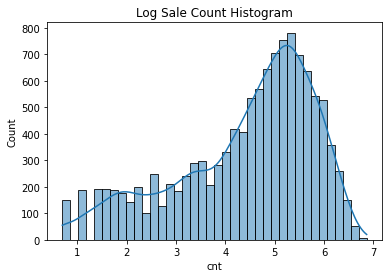

In [148]:
# log canttidad
plt.title('Log Sale Count Histogram')
train_target_log_d = np.log1p(train_target)
sns.histplot(train_target_log, kde=True)
plt.show()

In [147]:
df_test_d.columns == train_feature_d.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [155]:
#spliteo de los datos
X_train_d, X_validation_d, y_train_d, y_validation_d = train_test_split(train_feature_d, train_target_log_d, test_size=0.3, random_state=2000)
X_train_d.shape, X_validation_d.shape, y_train_d.shape, y_validation_d.shape

((8399, 14), (3600, 14), (8399,), (3600,))

In [156]:
for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train_d, X_validation_d, y_train_d, y_validation_d)

# RandomForestRegressor
RMSLE: 0.301
# GradientBoostingRegressor
RMSLE: 0.289
# XGBRegressor
RMSLE: 0.258
# LGBMRegressor
RMSLE: 0.296


In [157]:
mod = [RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, LGBMRegressor]
for i in mod:
    rf = i()
    nom = str(i)
    print('puntajes de CV para' +  nom)
    print(np.mean(cross_val_score(rf, X_train_d, y_train_d, cv=5)))
#los resultados de cross values son muy bajos asi que no tomamos este camino    

puntajes de CV para<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.12928371456628776
puntajes de CV para<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.221918684880616
puntajes de CV para<class 'xgboost.sklearn.XGBRegressor'>
0.24259780168316974
puntajes de CV para<class 'lightgbm.sklearn.LGBMRegressor'>
0.22428390450370136


_____________________________________________________________

Prediccion con XGBRegressor

In [95]:
#realizamos la prediccion 
prediccion1 = xgb_reg.predict(test_fin)
prediccion1[0:10]

array([2.656594 , 2.4711301, 3.254489 , 4.238904 , 4.9187956, 5.531478 ,
       6.062956 , 6.20468  , 6.129365 , 6.6968803], dtype=float32)

In [96]:
#revertimos el logaritmo
prediccion_cnt = np.expm1(prediccion1)
prediccion_cnt[0:10]

array([ 13.24768 ,  10.835815,  24.906372,  68.331825, 135.8377  ,
       251.51683 , 428.64352 , 494.0605  , 458.1445  , 808.87537 ],
      dtype=float32)

In [97]:
#redondeamos los dato sin decimales
prediccion_cnt = np.round(prediccion_cnt, 0)
prediccion_cnt

array([ 13.,  11.,  25., ..., 133.,  79.,  47.], dtype=float32)

In [99]:
#convierto a DF y renombro columa
df = pd.DataFrame(prediccion_cnt)
df.rename(columns={0:'pred'}, inplace=True)

In [101]:
subircsv('_csv', 'xgb_reg', 'csv', df)

Predicción con RandomForestRegressor

In [53]:
prediccion = rf_reg.predict(test_fin)
prediccion[0:10]

array([2.47585568, 1.99513602, 3.11708565, 5.26206718, 5.25389177,
       5.74326657, 6.10124905, 6.24503042, 6.33575109, 6.35561765])

In [55]:
#Volver a los valores originales cantidad
prediccion_cnt = np.expm1(prediccion)
prediccion_cnt[0:10]

array([ 10.8918784 ,   6.35320312,  21.5804762 , 191.87979682,
       190.30935329, 311.0821847 , 445.41501661, 514.44490303,
       563.39315242, 574.71782338])

In [59]:
prediccion_cnt = np.round(prediccion_cnt, 0)
prediccion_cnt

array([ 11.,   6.,  22., ..., 121.,  97.,  44.])

In [60]:
df = pd.DataFrame(prediccion_cnt)
df.rename(columns={0:'pred'}, inplace=True)
predic = pd.concat([df_test, df], axis=1)

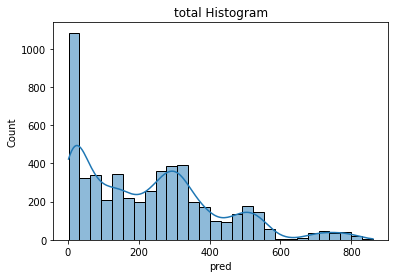

In [70]:
plt.title('total Histogram')
sns.histplot(predic['pred'], kde=True)
plt.show()

In [212]:
#subircsv('_csv', 'rf_reg', 'csv', df['pred'])